In [1]:
import torch
from torch import nn
from torchinfo import summary

from IPython.display import display as d

from typing import List, Dict, Union

import numpy as np

from omegaconf import OmegaConf

import matplotlib.pyplot as plt

from einops import rearrange

import lightning as L

In [2]:
from src.data.components.dataset import CreditsHistoryDataset
from src.data.components.targets_indexes_reader import TargetsReader, IndexesReader
from src.data.components.data_reader import DataReader
from src.utils.sampler import SamplerFactory

# Multitask research

In [3]:
emb_dim = 128

In [4]:
sample = torch.randint(0, 4, (5, ))

In [5]:
d(sample)

tensor([3, 0, 2, 2, 1])

In [6]:
a = nn.Embedding(num_embeddings=4, embedding_dim=8)

In [7]:
d(dict(a.named_parameters()))

{'weight': Parameter containing:
 tensor([[ 0.7905,  0.8748, -0.9494, -0.0320, -0.0461,  0.0173, -0.0866,  0.0108],
         [-0.9283, -0.0698,  0.4816, -0.3519, -0.2994,  0.3422, -0.7389,  0.8548],
         [-0.6415,  0.8164,  0.9165,  1.8407, -0.9568,  1.1694,  0.9635, -0.1062],
         [-1.5664,  1.1292,  0.6802,  1.9366, -1.8036,  0.9650,  2.2666, -1.3979]],
        requires_grad=True)}

In [8]:
d(a(sample))

tensor([[-1.5664,  1.1292,  0.6802,  1.9366, -1.8036,  0.9650,  2.2666, -1.3979],
        [ 0.7905,  0.8748, -0.9494, -0.0320, -0.0461,  0.0173, -0.0866,  0.0108],
        [-0.6415,  0.8164,  0.9165,  1.8407, -0.9568,  1.1694,  0.9635, -0.1062],
        [-0.6415,  0.8164,  0.9165,  1.8407, -0.9568,  1.1694,  0.9635, -0.1062],
        [-0.9283, -0.0698,  0.4816, -0.3519, -0.2994,  0.3422, -0.7389,  0.8548]],
       grad_fn=<EmbeddingBackward0>)

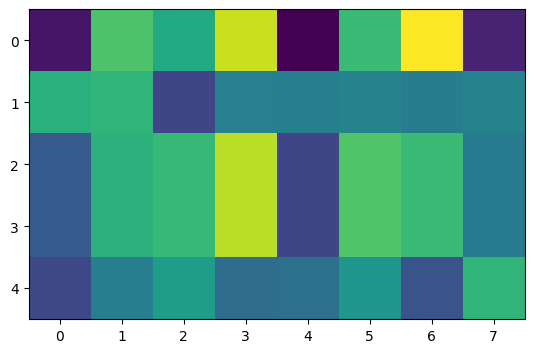

In [9]:
plt.imshow(a(sample).detach())

In [153]:
d(torch.concatenate([torch.stack(item).T for item in a]).unbind(dim=1))

(tensor([1, 2, 3, 1, 2, 3]), tensor([2, 3, 4, 2, 3, 4]))

In [6]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, input_size: int, hidden_size: int = 128, dropout=0.1):
        super().__init__()

        self.position_wise_layer = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size)
        )

        self.layer_norm = nn.LayerNorm(input_size, eps=1e-6)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        residual = x

        x = self.position_wise_layer(x)
        x = self.dropout(x)
        
        x += residual

        x = self.layer_norm(x)

        return x

In [31]:
class FooModel(nn.Module):
    def __init__(self, input_size: int, hidden_size: int = 128, max_seq_len: int = 50, dropout=0.1):
        super().__init__()

        self.position_wise_forward = PositionwiseFeedForward(
            input_size=emb_dim, 
            hidden_size=emb_dim * 2, 
            dropout=dropout
        )

        self.linear_layer = nn.Linear(emb_dim, 1)

        self.avg_pool = nn.AvgPool1d(kernel_size=max_seq_len)

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        x = self.position_wise_forward(inputs)

        x = self.linear_layer(x).squeeze()

        x = self.avg_pool(x)

        return x

In [7]:
some_batch = (torch.randn(size=(32, 50, emb_dim)), torch.randint(0, 2, (32, ), dtype=torch.float32))

In [32]:
some_model = FooModel(emb_dim, emb_dim * 2, 50)

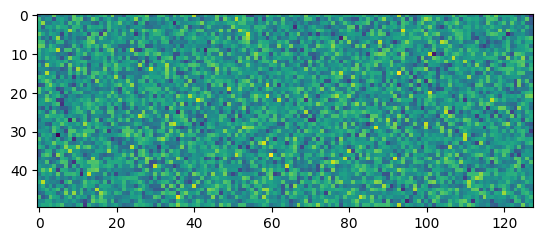

In [18]:
plt.imshow(some_batch[0][0])

In [33]:
d(some_model(some_batch[0]).size())

torch.Size([32, 1])

In [34]:
from torchmetrics.classification.auroc import BinaryAUROC

In [70]:
class GINI(BinaryAUROC):
    def __init__(self) -> None:
        super(GINI, self).__init__()
        
    def forward(self, logits: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        return (2. * super().forward(logits, labels) - 1.) * 100.
    
    # def compute(self) -> torch.Tensor:
    #     return super().compute()

In [71]:
a = GINI()

In [72]:
d(a(some_model(some_batch[0]), some_batch[1]))

tensor(43.7500)

In [119]:
d(some_model(some_batch[0]))

tensor([ 0.0903,  0.0469,  0.0347, -0.1100,  0.0162,  0.0895,  0.0320,  0.1441,
         0.0787,  0.0022,  0.0888, -0.0043,  0.1492, -0.0996,  0.0271,  0.0832,
        -0.0649,  0.0250,  0.0833, -0.0095,  0.1098,  0.1297,  0.0403,  0.0176,
        -0.0573, -0.0441, -0.1633,  0.0786, -0.0913,  0.0039, -0.0435, -0.0718],
       grad_fn=<MeanBackward1>)

In [86]:
d(a._buffers)

OrderedDict()

In [120]:
d((0.5749 * 2 - 1) * 100)

14.979999999999993

In [73]:
d(a.compute())

tensor(0.7188)

In [31]:
d(some_model.training_step(some_batch))

tensor(0.6924)
tensor(11.7409)
tensor(0.5587) 



/home/danil/projects/torch_template/.venv/lib/python3.11/site-packages/lightning/pytorch/core/module.py:436: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


{'loss': tensor(0.6924, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)}

# Dataset

In [3]:
from src.data.components.collate import ModelInput, SingleForwardState, BaseCollator, ModelOutput

In [4]:
def set_sampler(targets: dict, n_samples: int = 1000, replacement: bool = True):

    targets = np.asarray(list(targets.values()))
    
    sampler_factory = SamplerFactory(
        targets=targets, 
        n_samples=n_samples,
        replacement=replacement
    )
    return sampler_factory.balanced_random_sampler()

In [5]:
def initialize_data(features_path: str, data_path: str, indexes_path: str, targets_path: str, use_sampler: bool = True, batch_size: int = 32):
    features_dict = OmegaConf.load(features_path)

    data_reader = DataReader(data_path=data_path)
    data_reader.setup()

    indexes = IndexesReader(train_path=indexes_path).train_indexes

    targets = TargetsReader(targets_path).targets

    targets = {idx: targets.get(idx) for idx in indexes}

    dataset = CreditsHistoryDataset(
        data=data_reader, 
        targets=targets,
        indexes=indexes,
        features=features_dict
    )

    print(f"dataset sample: {dataset[0]}")

    train_sampler = set_sampler(
        targets=dataset.targets, 
        n_samples=10000,
        replacement=False
    ) if use_sampler else None

    dataloader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=BaseCollator(max_seq_len=20),
        sampler=train_sampler,
        drop_last=True
    ) 

    return dataloader, features_dict

In [6]:
test_dataloader, _ = initialize_data(
    "configs/data/features/features_credits_aggregated_v4.yaml",
    "./data/credits-history/serialized/serialized_first_part_v4",
    "./data/credits-history/indexes/ser_full_0_indexes/train_indexes.pickle",
    "./data/credits-history/targets/targets_dict.pickle",
    use_sampler=False,
    batch_size=1024
)

dataset sample: {'numerical': tensor([[0.9147, 0.2640, 1.0005, 0.0000],
        [0.1462, 1.5110, 2.0127, 0.0000],
        [0.3494, 0.8115, 1.5090, 0.0000],
        [0.3494, 0.8115, 1.5090, 0.0000],
        [0.2703, 1.0098, 1.6636, 0.0000],
        [1.8310, 0.0262, 0.1688, 0.0000],
        [0.0139, 2.6218, 2.6531, 0.0000],
        [1.1378, 0.0262, 0.0925, 0.0000],
        [0.3494, 0.8115, 1.5090, 0.0000],
        [2.7473, 0.0262, 0.4866, 0.0000],
        [0.4447, 0.6416, 1.3662, 0.0000],
        [0.2035, 1.2411, 1.8312, 0.0000]]), 'categorical': tensor([[ 9,  8,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  8,  9,  0,  0,  0,  0,
          0,  0,  0,  0],
        [ 6,  9, 15,  0,  0,  0,  0,  0,  0,  0,  2,  7,  6,  6,  0,  0,  0,  0,
          0,  0,  0,  0],
        [ 2,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  2,  2,  0,  0,  0,  0,
          0,  0,  0,  0],
        [ 6,  1,  1,  0,  0,  0,  0,  0,  2,  0,  0,  1,  2,  2,  0,  0,  0,  0,
          0,  0,  0,  0],
        [ 7,  9,  5, 

In [7]:
dataloader, features_dict = initialize_data(
    "configs/data/features/features_credits_aggregated_v4.yaml",
    "./data/credits-history/serialized/serialized_first_part_v4",
    "./data/credits-history/indexes/ser_full_0_indexes/train_indexes.pickle",
    "./data/credits-history/targets/targets_dict.pickle"
)

dataset sample: {'numerical': tensor([[0.9147, 0.2640, 1.0005, 0.0000],
        [0.1462, 1.5110, 2.0127, 0.0000],
        [0.3494, 0.8115, 1.5090, 0.0000],
        [0.3494, 0.8115, 1.5090, 0.0000],
        [0.2703, 1.0098, 1.6636, 0.0000],
        [1.8310, 0.0262, 0.1688, 0.0000],
        [0.0139, 2.6218, 2.6531, 0.0000],
        [1.1378, 0.0262, 0.0925, 0.0000],
        [0.3494, 0.8115, 1.5090, 0.0000],
        [2.7473, 0.0262, 0.4866, 0.0000],
        [0.4447, 0.6416, 1.3662, 0.0000],
        [0.2035, 1.2411, 1.8312, 0.0000]]), 'categorical': tensor([[ 9,  8,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  8,  9,  0,  0,  0,  0,
          0,  0,  0,  0],
        [ 6,  9, 15,  0,  0,  0,  0,  0,  0,  0,  2,  7,  6,  6,  0,  0,  0,  0,
          0,  0,  0,  0],
        [ 2,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  2,  2,  0,  0,  0,  0,
          0,  0,  0,  0],
        [ 6,  1,  1,  0,  0,  0,  0,  0,  2,  0,  0,  1,  2,  2,  0,  0,  0,  0,
          0,  0,  0,  0],
        [ 7,  9,  5, 

In [ ]:
d(next(iter(dataloader)))

# Model

## Get sample check 

In [54]:
def get_sample():
    batch = next(iter(dataloader))

    x = ModelInput(
        numerical=batch.numerical,
        categorical=batch.categorical,
        mask=batch.mask
    )

    labels = batch.targets

    return x, labels

In [55]:
sample = get_sample()

In [56]:
d(sample[0].numerical.size())

torch.Size([32, 20, 4])

In [57]:
d((~sample[0].mask).sum(dim=1).size())

torch.Size([32])

In [58]:
d(rearrange(sample[0].numerical, "N L H -> N H L"))

tensor([[[0.4447, 0.3494, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.6416, 0.8115, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [1.3662, 1.5090, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[1.8310, 0.0964, 2.9296,  ..., 0.0000, 0.0000, 0.0000],
         [0.0262, 1.8259, 0.0262,  ..., 0.0000, 0.0000, 0.0000],
         [0.1688, 2.2093, 0.6314,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.7129, 0.4447, 1.6974,  ..., 0.0000, 0.0000, 0.0000],
         [0.3710, 0.0262, 0.0936,  ..., 0.0000, 0.0000, 0.0000],
         [1.1128, 0.0587, 0.8012,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        ...,

        [[0.3494, 0.9147, 0.0139,  ..., 0.0000, 0.0000, 0.0000],
         [0.8115, 0.2640, 2.6218,  ..., 0.0000, 0.0000, 0.0000],
         [1.5090, 1.0005, 2.6531,  ..., 0.0000, 0.0000, 0.0000],
     

## Model layers check

In [59]:
EMB_DIM = 16

In [60]:
class EmbeddingLayer(nn.Module):
    def __init__(
            self,
            categorical_features: dict
        ) -> None:
        super(EmbeddingLayer, self).__init__()

        self.categorical_features = categorical_features

        self.embeddings = nn.ModuleList()

        for vocab_size, emb_dim in self.categorical_features.values():

            embedding = nn.Embedding(
                num_embeddings=vocab_size, 
                embedding_dim=emb_dim
            )

            nn.init.xavier_normal_(embedding.weight, gain=nn.init.calculate_gain('relu'))

            self.embeddings.append(embedding)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        x = torch.concatenate(
            [embedding(x[..., idx]) for idx, embedding in enumerate(self.embeddings)], dim=-1
        ) # size = (B, L, first_emb_dim)
        
        return x

    
class EncoderLayer(nn.Module):
    def __init__(
            self,
            numerical_features: List[str],
            categorical_features: Dict[str, List[int]],
            embedding_dim: int = 16,
            dropout_inputs: float = 0.5,
            non_linear: bool = False,
            num_batch_norm: bool = True
        ) -> None:
        super(EncoderLayer, self).__init__()

        self.dropout = nn.Dropout(p=dropout_inputs)

        self.numerical_features = numerical_features
        self.categorical_features = categorical_features

        _first_emb_dim = sum([shape[-1] for shape in self.categorical_features.values()])

        self.embeddings = EmbeddingLayer(
            categorical_features=categorical_features
        )

        if non_linear:
            self.out_linear_block = nn.Sequential(
                nn.Linear(
                    _first_emb_dim + len(self.numerical_features), 
                    embedding_dim
                ),
                nn.ReLU(),

                nn.Linear(embedding_dim, embedding_dim)
            )
        else:
            self.out_linear_block = nn.Linear(
                _first_emb_dim + len(self.numerical_features), 
                embedding_dim
            )

        if num_batch_norm:
            self.num_bn = nn.BatchNorm1d(len(self.numerical_features))
        else: 
            self.num_bn = None


    def forward(self, inputs: ModelInput) -> SingleForwardState:

        embeddings = self.embeddings(inputs.categorical)

        if self.num_bn is None:
            x_num = inputs.numerical
        else:
            x_num = rearrange(inputs.numerical, "N L H -> N H L")

            x_num = self.num_bn(x_num)

            x_num = rearrange(x_num, "N H L -> N L H")

        x = torch.concatenate((x_num, embeddings), dim=-1)

        x = self.dropout(x)
        x = self.out_linear_block(x)

        return SingleForwardState(
            sequences=x, 
            mask=inputs.mask
        )

In [61]:
enc = EncoderLayer(
    numerical_features=features_dict["numerical"],
    categorical_features=features_dict["categorical"],
    embedding_dim=EMB_DIM,
    dropout_inputs=0.3
)

In [62]:
x_enc = enc(sample[0])

In [63]:
x_enc = enc(next(iter(test_dataloader)))

In [64]:
d(x_enc.sequences.size())

torch.Size([1024, 20, 16])

In [69]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 40, encoding_capacity: float = 10_000.0):
        super().__init__()

        self.dropout = nn.Dropout(p=dropout)
        
        encoding_capacity = torch.tensor(encoding_capacity)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)

        div_term = torch.exp(-torch.arange(0, d_model, 2) * torch.log(encoding_capacity) / d_model)
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.pe = pe.unsqueeze(0)
        

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]

        return self.dropout(x)

In [70]:
check_pe = PositionalEncoding(EMB_DIM, 0.0, 20)(x_enc.sequences)

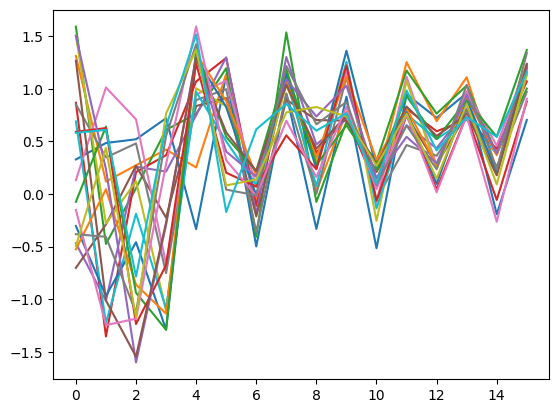

In [71]:
for i in range(20):
    plt.plot(range(16), check_pe[-1, i, :].detach())
plt.show()

In [72]:
d(check_pe.size())

torch.Size([1024, 20, 16])

In [73]:
d(x_enc.mask)

tensor([[False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        ...,
        [False, False,  True,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True]])

In [74]:
d(x_enc.sequences.size())

torch.Size([1024, 20, 16])

In [75]:
d(sample[0].categorical.size())

torch.Size([32, 20, 22])

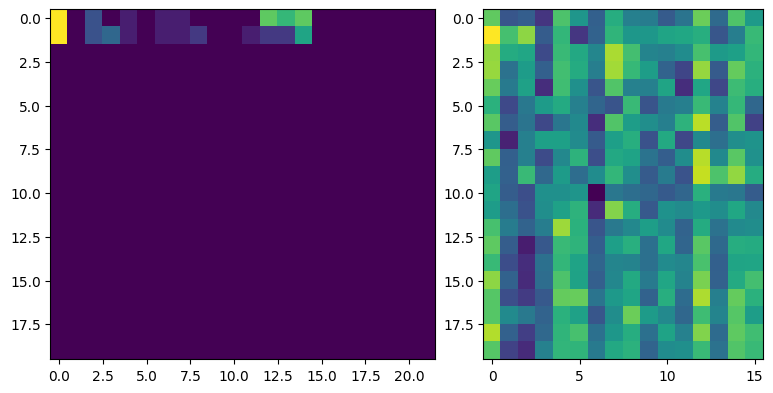

In [78]:
figure = plt.figure(figsize=(18, 10))

ax = figure.add_subplot(2, 2, 1)
ax.imshow(sample[0].categorical[0])

ax = figure.add_subplot(2, 1, 1)
ax.imshow(x_enc.sequences[0].detach())

In [79]:
from src.models.components.base_transformer.encoder_decoder import Encoder, LUNAEncoder
from src.models.components.base_transformer.sub_layers import EncoderLayer, LUNAEncoderLayer
from src.models.components.base_transformer.multihead_attention import MultiHeadAttention, LinearUnifiedNestedAttention
from src.models.components.base_transformer.positionwise_ff import PositionwiseFeedForward
from src.models.components.base_transformer.transformer import BaseTransformer
from src.models.components.pooling.agg_pooling import ConvPooling

In [80]:
EMB_DIM = 16

In [81]:
import torch 
from torch import nn 

from src.models.components.utils.clone_modules import clone_modules

from typing import Tuple


class ScaledDotProductAttention(nn.Module):
    def __init__(self, temperature: float, dropout: float = 0.1):
        super(ScaledDotProductAttention, self).__init__()

        self.temperature = torch.sqrt(torch.tensor(temperature))
        self.softmax_dropout = nn.Sequential(
            nn.Softmax(dim=-1),
            nn.Dropout(dropout)
        )


    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask: torch.Tensor = None) -> torch.Tensor:
        # (B, h, L, d)

        print("qkv", query.size(), key.size(), value.size())

        attn = torch.matmul(query, key) / self.temperature

        print("attn", attn.size())

        # (B, h, L, L) or (B, h, L, d_proj)

        if mask is not None:
            # mask (B, 1, L, 1) ~ same mask applied to all h heads and all L or d_k sequences
            print(mask.unsqueeze(dim=1).unsqueeze(dim=1).size())
            attn.masked_fill_(~mask.unsqueeze(dim=1).unsqueeze(dim=1), -1.0e9)
        
        attn = self.softmax_dropout(attn)

        context = torch.matmul(attn, value)

        print("context", context.size())

        # (B, h, L, d)

        return context, attn


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, n_heads: int = 1, dropout: float = 0.1, seq_len: int = None, d_proj: int = None):
        super(MultiHeadAttention, self).__init__()

        self.linears = clone_modules(nn.Linear(d_model, d_model * n_heads), 3)

        self.seq_len = seq_len

        if self.seq_len is not None:
            if d_proj is None:
                d_proj = self.seq_len // 4

            self.E_projection = nn.Linear(self.seq_len, d_proj)
            self.F_projection = nn.Linear(self.seq_len, d_proj)

        self.attention = ScaledDotProductAttention(d_model, dropout)

        self.out_block = nn.Linear(d_model * n_heads, d_model)

        self.d_model = d_model
        self.n_heads = n_heads
        

    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask: torch.Tensor = None) -> torch.Tensor:
        # (B, L, d)
        n_batches = query.size(0)

        query, key, value = [
            layer(x).view(n_batches, -1, self.n_heads, self.d_model).transpose(1, 2) \
                for layer, x in zip(self.linears, (query, key, value))
        ]

        # q, k, v ~ (B, h, L, d) # h = num_heads

        if self.seq_len is not None:
            key = self.E_projection(key.transpose(-2, -1))
            value = self.F_projection(value.transpose(-2, -1)).transpose(-2, -1)
            # q ~ (B, h, L, d)
            # k ~ (B, h, d, d_k) => P ~ (B, h, L, d_k)
            # v ~ (B, h, d_k, d) => matmul(P, v) ~ (B, h, L, d)
        else:
            key = key.transpose(-2, -1)

        context, _ = self.attention(query, key, value, mask)

        # (B, h, L, d)

        # .contiguous() -> makes a copy of the tensor with its own layout ~ for view
        context = context.transpose(1, 2).contiguous().view(n_batches, -1, self.d_model * self.n_heads)

        # (B, L, d * h)

        context = self.out_block(context)

        # (B, L, d)

        return context
    

# LUNA
class LinearUnifiedNestedAttention(nn.Module):
    def __init__(self, d_model: int, n_heads: int = 1, dropout: float = 0.1, seq_len: int = None, d_proj: int = None):
        super(LinearUnifiedNestedAttention, self).__init__()

        self.pack_attention = MultiHeadAttention(d_model, n_heads, dropout, seq_len, d_proj)

        self.unpack_attention = MultiHeadAttention(d_model, n_heads, dropout, seq_len, d_proj)
        
        self.d_model = d_model
        self.n_heads = n_heads

    
    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, aggregates: torch.Tensor, mask: torch.Tensor = None) -> Tuple[torch.Tensor]:
        print(query.size(), key.size(), value.size(), aggregates.size())

        packed_context = self.pack_attention(aggregates, key, value, mask)

        unpacked_context = self.unpack_attention(query, packed_context, packed_context)

        return unpacked_context, packed_context

In [89]:
attn = BaseTransformer(
    use_decoder=False,
    encoder=LUNAEncoder(
        luna_encoder_layer=LUNAEncoderLayer(
            luna=LinearUnifiedNestedAttention(EMB_DIM, 4),
            feed_forward=PositionwiseFeedForward(EMB_DIM, activation_type="relu")
        ),
        n_layers=1, 
        n_aggregates=8
    )
)

In [90]:
d(attn)

BaseTransformer(
  (encoder): LUNAEncoder(
    (layers): ModuleList(
      (0): LUNAEncoderLayer(
        (luna_layer): LinearUnifiedNestedAttention(
          (pack_attention): MultiHeadAttention(
            (linears): ModuleList(
              (0-2): 3 x Linear(in_features=16, out_features=64, bias=True)
            )
            (attention): ScaledDotProductAttention(
              (softmax_dropout): Sequential(
                (0): Softmax(dim=-1)
                (1): Dropout(p=0.1, inplace=False)
              )
            )
            (out_block): Linear(in_features=64, out_features=16, bias=True)
          )
          (unpack_attention): MultiHeadAttention(
            (linears): ModuleList(
              (0-2): 3 x Linear(in_features=16, out_features=64, bias=True)
            )
            (attention): ScaledDotProductAttention(
              (softmax_dropout): Sequential(
                (0): Softmax(dim=-1)
                (1): Dropout(p=0.1, inplace=False)
              

In [91]:
d(x_enc.mask.unsqueeze(dim=1).expand(-1, 8, -1).size())

torch.Size([1024, 8, 20])

In [92]:
x_att = attn(x_enc)

torch.Size([1024, 20, 16]) torch.Size([1024, 20, 16]) torch.Size([1024, 20, 16]) torch.Size([1024, 8, 16])
qkv torch.Size([1024, 4, 8, 16]) torch.Size([1024, 4, 16, 20]) torch.Size([1024, 4, 20, 16])
attn torch.Size([1024, 4, 8, 20])
torch.Size([1024, 1, 1, 20])
context torch.Size([1024, 4, 8, 16])


qkv torch.Size([1024, 4, 20, 16]) torch.Size([1024, 4, 16, 8]) torch.Size([1024, 4, 8, 16])
attn torch.Size([1024, 4, 20, 8])
context torch.Size([1024, 4, 20, 16])


In [93]:
d(x_att)

TwoBranchForwardState(main_sequences=tensor([[[ 9.7050e-01, -7.1419e-01, -1.6031e+00,  ..., -4.3073e-01,
           1.2074e-01, -1.0225e+00],
         [ 1.9632e+00,  3.9248e-01,  9.7789e-01,  ..., -1.1369e+00,
          -6.1153e-01, -3.0542e-01],
         [ 7.3560e-01, -4.0554e-02, -9.7706e-01,  ..., -6.7422e-01,
          -7.8450e-01,  3.1163e-01],
         ...,
         [ 1.3111e+00, -6.3186e-01,  4.3434e-03,  ..., -2.4119e-01,
          -1.8406e-01, -1.4614e+00],
         [ 9.6677e-01, -1.2168e+00, -2.2300e+00,  ..., -9.3764e-01,
          -5.7574e-02,  3.9302e-01],
         [ 4.7234e-01, -9.8698e-01, -1.9148e+00,  ..., -5.2198e-01,
          -6.7993e-02, -2.7126e-01]],

        [[ 1.1746e+00, -5.2964e-01, -1.3359e-01,  ..., -7.2424e-01,
           1.0181e+00, -1.6134e+00],
         [ 1.6461e+00, -1.2307e+00, -6.6614e-01,  ..., -1.1133e+00,
           4.2077e-01, -1.1325e+00],
         [ 8.8398e-01, -9.8607e-01, -9.5912e-01,  ..., -4.2724e-01,
           6.0135e-01, -6.8526e-01],
  

In [44]:
d(x_att.main_sequences.size(), x_att.aggregates.size())

torch.Size([1024, 50, 16])

torch.Size([1024, 8, 16])

In [33]:
d(x_att.sequences.size())

torch.Size([1024, 50, 16])

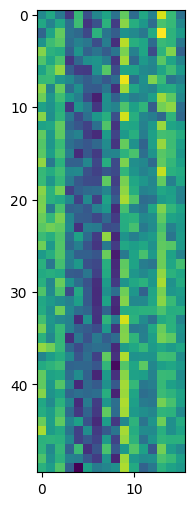

In [34]:
figure = plt.figure(figsize=(6, 6))

ax = figure.add_subplot()
ax.imshow(x_att.sequences[0].detach())

In [35]:
class GRUAggregator(nn.Module):
    def __init__(
            self,
            hidden_size: int, 
            num_layers_gru: int = 1,
            bidirectional: bool = False,
            dropout_gru: float = 0.0
    ) -> None:
        super(GRUAggregator, self).__init__()

        self.gru = nn.GRU(
            input_size=hidden_size,
            hidden_size=hidden_size,
            batch_first=True,
            num_layers=num_layers_gru,
            bidirectional=bidirectional,
            dropout=dropout_gru
        )

    def forward(self, x: SingleForwardState) -> SingleForwardState:

        lengths = (~x.mask).sum(dim=1)

        packed_sequences = torch.nn.utils.rnn.pack_padded_sequence(
            input=x.sequences, 
            lengths=lengths, 
            batch_first=True, 
            enforce_sorted=False
        )

        _, hidden_state = self.gru(packed_sequences)

        return SingleForwardState(
            sequences=hidden_state[-1],
            mask=x.mask
        )

In [37]:
pooling = ConvPooling(EMB_DIM)

In [38]:
gru = GRUAggregator(
    hidden_size=EMB_DIM,
    num_layers_gru=2
)

In [39]:
x_gru = gru(x_att)
x_pooled = pooling(x_att)

In [44]:
d(x_gru.sequences.size(), x_pooled.representations.size())

torch.Size([1024, 16])

torch.Size([1024, 16])

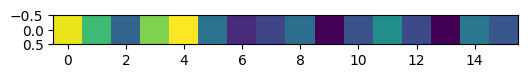

In [48]:
figure = plt.figure(figsize=(6, 6))

ax = figure.add_subplot()
plt.show(ax.imshow(x_gru.sequences[0].detach().unsqueeze(dim=0)))

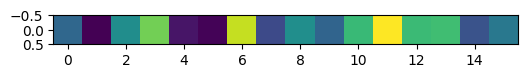

In [51]:
figure = plt.figure(figsize=(6, 6))

ax = figure.add_subplot()
plt.show(ax.imshow(x_pooled.representations[0].detach().unsqueeze(dim=0)))

In [29]:
from src.models.components.pooling.agg_pooling import ConvPooling

In [97]:
class PoolingType(nn.Module):
    num_poolings: int = None

    def __init__(self):
        super(PoolingType, self).__init__()

def first_pooling(hidden_state: torch.Tensor, dim: int = 1):
    assert len(hidden_state.size()) == 3, \
        "hidden state size should be (batch_size x num_seq x seq_len)"

    return hidden_state[:, 0, :] if dim == 1 else hidden_state[:, :, 0]


def last_pooling(hidden_state: torch.Tensor, lengths: torch.Tensor, dim: int = 1):
    assert len(hidden_state.size()) == 3, \
        "hidden state size should be (batch_size x num_seq x seq_len)"
    
    if dim == 1:
        hidden_state = hidden_state[torch.arange(hidden_state.size(0)), lengths - 1, :] # (N, L, B)
    elif dim == 2:
        hidden_state = hidden_state[torch.arange(hidden_state.size(0)), :, lengths - 1] # (N, B, L)
    else:
        raise NotImplementedError("dim is not valid, select dim from the <[1, 2]>")

    return hidden_state


def avg_pooling(hidden_state: torch.Tensor, lengths: torch.Tensor, dim: int = 1):
    assert len(hidden_state.size()) == 3, \
        "hidden state size should be (batch_size x num_seq x seq_len) or (num_seq x seq_len)"

    return torch.mean(hidden_state, dim=dim)


class FirstLastAvgPoolings(PoolingType):
    def __init__(self, dim: int = 1):
        super(FirstLastAvgPoolings, self).__init__()

        self.dim = dim

        self.num_poolings = 3

    def forward(self, hidden_state: torch.Tensor):
        pooled_results = [
            first_pooling(hidden_state, self.dim),
            last_pooling(hidden_state, self.dim),
            avg_pooling(hidden_state, self.dim)
        ]
        hidden_state_pooled = torch.concatenate(pooled_results, dim=self.dim)

        return hidden_state_pooled
    

POOLING_MAPPING = {
    "first_last_avg": FirstLastAvgPoolings
}


class Pooling(nn.Module):
    def __init__(
            self, 
            emb_dim: int,
            pooling_type: str = "all", 
            use_batch_norm: bool = True,
            dim: int = 1
        ) -> None:
        super(Pooling, self).__init__()

        self.dim = dim

        pooling_types = list(POOLING_MAPPING.keys())
        assert pooling_type in pooling_types, \
            f"You should specify pooling type from {pooling_types}, not {pooling_type}"
        
        self.pooling_layer = POOLING_MAPPING[pooling_type](dim=dim)

        input_size = self.pooling_layer.num_poolings * emb_dim

        self.agg_layer = nn.Linear(input_size, emb_dim)

        self.batch_norm = nn.BatchNorm1d(emb_dim) if use_batch_norm else nn.Identity()
        
    def forward(self, hidden_state: SingleForwardState) -> ModelOutput:
        x = self.pooling_layer(hidden_state.sequences)
        x = self.batch_norm(self.agg_layer(x))

        return ModelOutput(
            representations=x,
            logits=None
        )

In [98]:
x_pooled_ = Pooling(emb_dim=32, pooling_type="first_last_avg", use_batch_norm=False, dim=1)

In [99]:
d(x_pooled_)

Pooling(
  (pooling_layer): FirstLastAvgPoolings()
  (agg_layer): Linear(in_features=96, out_features=32, bias=True)
  (batch_norm): Identity()
)

In [100]:
x_pooled = x_pooled_(x_gru)

In [101]:
d(x_pooled.representations.size())

torch.Size([32, 32])

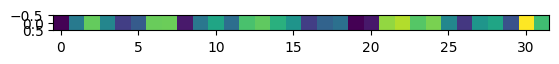

In [102]:
plt.imshow(x_pooled.representations[0].detach().unsqueeze(dim=0))

In [12]:
from src.data.components.collate import ModelOutput
from typing import List, Tuple

In [13]:
ACTIVATION_TYPE_MAPPING = {
    "tanh": nn.Tanh,
    "gelu": nn.GELU,
    "relu": nn.ReLU,
    "none": nn.Identity
}

def init_linear_block_weights(layer):
    if isinstance(layer, nn.Linear):
        nn.init.xavier_uniform_(layer.weight, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(layer.bias)

class LinearBlock(nn.Module):
    def __init__(
            self, 
            in_features: int, 
            out_features: int = 1, 
            num_layers: int = 3, 
            dropout_rate: float = 0.0, 
            activation_type: str = "tanh",
            use_batch_norm: bool = False,
            bias: bool = True
        ) -> None:
        super(LinearBlock, self).__init__()

        self.in_features = in_features

        self.dropout = nn.Dropout(p=dropout_rate)

        if activation_type is None:
            self.act = ACTIVATION_TYPE_MAPPING["tanh"]
        elif activation_type in ACTIVATION_TYPE_MAPPING.keys():
            self.act = ACTIVATION_TYPE_MAPPING[activation_type]
        else: 
            NotImplementedError(f"activation_type must be in <{list(ACTIVATION_TYPE_MAPPING.keys())}>")

        if use_batch_norm:
            self.layer_norm = nn.BatchNorm1d
        else:
            self.layer_norm = nn.LayerNorm

        self.linear_block = nn.Sequential(
            *[
                nn.Sequential(
                    *[
                        nn.Linear(in_features // (2 ** i), in_features // (2 ** (i + 1)), bias),
                        self.layer_norm(in_features // (2 ** (i + 1))),
                        self.act()
                    ]
                ) for i in range(num_layers)
            ]
        )
        

        self.out_block = nn.Linear(
            in_features=in_features // (2 ** num_layers), out_features=out_features
        )

        self.cls_layers = nn.Sequential(
            self.dropout,
            self.linear_block,
            self.out_block,
            self.act()
        )

        # weights init
        self.cls_layers.apply(init_linear_block_weights)


    def forward(self, x: ModelOutput) -> ModelOutput:
        logits = self.cls_layers(x.representations)

        return ModelOutput(
            representations=x.representations,
            logits=logits
        )


class MultiTaskLinearBlock(nn.Module):
    def __init__(
            self,
            heads: List[LinearBlock]
    ) -> None: 
        super(MultiTaskLinearBlock, self).__init__()

        self.heads = nn.ModuleList(heads)

    def forward(self, x: ModelOutput) -> ModelOutput:
        multi_state = [
            head(x).logits for head in self.heads
        ]

        logits = torch.concat(multi_state, dim=1) # size(batch_size, num_outputs)
        
        return ModelOutput(
            representations=x.representations,
            logits=logits
        )

In [48]:
x_out = MultiTaskLinearBlock(
    heads=[
        LinearBlock(32, 1, 2)
    ]
)(x_pooled)

In [49]:
d(x_out)

ModelOutput(representations=tensor([[-0.0807, -0.0925,  0.0185,  ...,  0.0862,  0.0276, -0.0489],
        [-0.0164, -0.0240,  0.0047,  ...,  0.0191,  0.0072, -0.0139],
        [-0.0550, -0.0686,  0.0153,  ...,  0.0614,  0.0193, -0.0378],
        ...,
        [-0.0029, -0.0036,  0.0004,  ...,  0.0021,  0.0021, -0.0017],
        [-0.1101, -0.1254,  0.0267,  ...,  0.1202,  0.0347, -0.0692],
        [-0.0092, -0.0124, -0.0006,  ...,  0.0077,  0.0030, -0.0051]],
       grad_fn=<SqueezeBackward1>), logits=tensor([[-0.3835],
        [-0.4595],
        [-0.3846],
        [-0.5128],
        [-0.4077],
        [-0.4268],
        [-0.4213],
        [-0.6295],
        [-0.4995],
        [-0.0691],
        [-0.4164],
        [-0.4121],
        [-0.3576],
        [-0.3559],
        [-0.3748],
        [-0.3683],
        [-0.3324],
        [-0.3280],
        [-0.3166],
        [-0.3467],
        [-0.4153],
        [-0.5702],
        [-0.4393],
        [-0.3760],
        [-0.3955],
        [-0.4136],
 

In [14]:
import time
import pandas as pd

In [15]:
import bitsandbytes as bnb

The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.


In [16]:
from src.utils.metrics import GINI

In [17]:
class Trainer:
    def __init__(
            self, 
            model: nn.Module, 
            optimizer: torch.optim.Optimizer, 
            criterion: nn.BCEWithLogitsLoss,
            train_dataloader: torch.utils.data.DataLoader, 
            scheduler: torch.optim.lr_scheduler.LRScheduler = None
        ) -> None:

        self.model = model
    
        self.criterion = criterion
        
        self.task_names = ["tanh_output"]
        self.task_weights = torch.tensor([1.0])

        self.train_data = train_dataloader

        self.optimizer = optimizer
        self.scheduler = scheduler

        self.gini = GINI()

        self.train_results = list()

    def multioutput_loss(self, logits: ModelOutput, targets: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # logits size is (batch_size, num_outputs)
        # targets size is (batch_size, 1)

        targets = targets.expand(size=(-1, len(self.task_names))) # to size like logits

        weighted_loss = self.task_weights * self.criterion(logits, targets)
        
        # (self.task_weights * self.criterion(logits, targets)).sum() / len(self.task_names)
        loss = weighted_loss.sum() / (len(weighted_loss) * len(self.task_names))
        branched_loss = (weighted_loss.sum(dim=0) / len(weighted_loss)).detach()

        return loss, branched_loss

    def fit(self, epochs: int = 3, show_step: int = 100):
        n_total_steps = len(self.train_data)

        loss_step = 0
        gini_step = 0

        for epoch in range(epochs):
            epoch_start_time = time.time()

            self.epoch = epoch
            
            print('Epoch %s/%s' % (epoch + 1, epochs))

            for step, batch in enumerate(self.train_data):
                self.optimizer.zero_grad(set_to_none=True)

                x = ModelInput(
                    numerical=batch.numerical,
                    categorical=batch.categorical,
                    lengths=batch.lengths
                )

                labels = batch.targets

                outputs = self.model(x)
        
                loss, _ = self.multioutput_loss(
                    logits=outputs.logits,
                    targets=labels
                )

                loss.backward()
                self.optimizer.step()

                loss_step += loss.item()
                gini_step += self.gini(outputs.logits[:, 0], labels.squeeze())

                self.train_results.append(
                    [
                        self.epoch * n_total_steps + step, 
                        loss.item()

                    ]
                )

                if (step + 1) % show_step == 0:
                    print(
                        f"Step [{step+1}/{n_total_steps}] | Time: {time.time() - epoch_start_time:.2f}s | Loss: {loss_step / show_step:.4f} | GINI: {gini_step / show_step:.1f}"
                    )
                    gini_step = 0
                    loss_step = 0

        self.train_writer = pd.DataFrame(self.train_results, columns=["step", "loss"])

        print('\nDone.')


    def __repr__(self):
        return f'''[INFO]\n{"-" * 60}\ndata: {self.data} \n{"-" * 60} \nmodel: {self.model} \n{"-" * 60} \noptimizer: {self.optimizer} \n{"-" * 60}'''

In [18]:
model = nn.Sequential(
    EncoderLayer(
        numerical_features=features_dict["numerical"],
        categorical_features=features_dict["categorical"],
        embedding_dim=32,
        dropout_inputs=0.1
    ),
    SimpleAttention1d(
        features_dim=32
    ),
    GRUSeqToSeq(
        hidden_size=32,
        num_layers_gru=1
    ),
    ConvPooling(
        pooling_type="avg", dim=1
    ),
    MultiTaskLinearBlock(
        heads=[
            LinearBlock(32, 1, 2)
        ]
    )
)

In [19]:
opt = bnb.optim.Adam8bit(model.parameters(), lr=1e-3, weight_decay=1e-5)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.99)

train_model = Trainer(
    model=model, 
    criterion=nn.BCEWithLogitsLoss(
        reduction="none"
    ),
    train_dataloader=dataloader, 
    optimizer=opt
)

In [ ]:
train_model.fit(epochs=3, show_step=30)

In [109]:
test_sample = next(iter(test_dataloader))

In [168]:
preds = model(test_sample).logits

In [169]:
d(GINI()(preds, test_sample.targets))

tensor(44.4487)

In [ ]:
# 1 - 40.82 ~ lr 1e-4
# 2 - 44.80 ~ lr 1e-2

In [118]:
sorted_preds = torch.concatenate((torch.sigmoid(preds), test_sample.targets), dim=1).sort(dim=0).values.detach()

In [123]:
from sklearn.metrics import roc_curve

In [126]:
fpr, tpr, _ = roc_curve(test_sample.targets, torch.sigmoid(preds).detach())

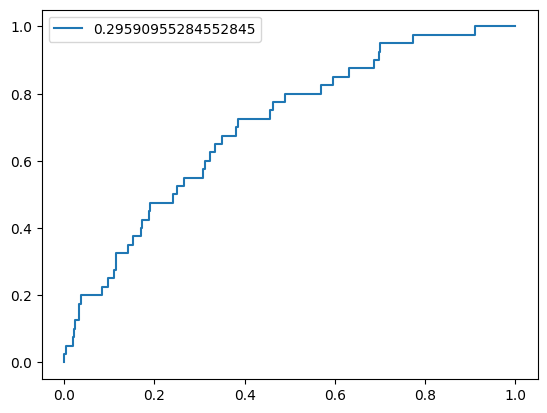

In [131]:
plt.plot(fpr, tpr, label=np.trapz(fpr, tpr))
plt.legend(loc=2)
plt.show()

# Pretrained model

In [32]:
import torch
from torch import nn

In [33]:
from src.models.ch_lit_module import CHLitModule
from IPython.display import display as d

In [35]:
class PretrainedModel(nn.Module):
    def __init__(self, ckpt_path: str):
        super().__init__()
        
        self.net = CHLitModule.load_from_checkpoint(ckpt_path, strict=False)
        self.net.eval()
        self.net.freeze()

    def forward(self, inputs):
        return self.net(inputs)

In [36]:
trained_model = PretrainedModel("logs/train/runs/2024-05-31_22-09-09/checkpoints/epoch_004.ckpt")

/home/danil/projects/LHT_credits_history/.venv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.


In [37]:
d(dict(trained_model.net.named_parameters()))

{'net.layers.0.embeddings.embeddings.0.weight': Parameter containing:
 tensor([[ 0.0197,  0.2683,  0.4016,  0.5582, -0.0171,  0.6085, -0.0866,  0.2796,
           0.0057, -0.5869, -0.0999, -0.1531, -0.4706, -0.1798, -0.0092, -0.4939],
         [ 0.0668,  0.1272, -0.2679, -0.0514, -0.0469, -0.2581,  0.2347, -0.2060,
           0.4216, -0.0268,  0.1113, -0.2695,  0.4489, -0.2100,  0.0434, -0.0974],
         [ 0.0340, -0.3196, -0.2078, -0.5003,  0.1283, -0.5217,  0.0745,  0.0812,
           0.1875, -0.5795,  0.1276, -0.6134, -0.5030,  0.2180,  0.0698,  0.7852],
         [ 0.5075, -0.0842, -0.1455, -0.5304, -0.3555, -0.4148, -0.1637,  0.3445,
           0.4151,  0.4096, -0.1276,  0.0018,  0.4474,  0.4780,  0.4084, -0.3658],
         [ 0.2444,  0.5850,  0.1382, -0.2082,  0.1010,  0.4734, -0.2528,  0.5090,
           0.1831, -0.0027, -0.0648, -0.4699, -0.0568,  0.0879,  0.0895,  0.3063],
         [ 0.6197, -0.4013, -0.4065, -0.1706,  0.4921,  0.2532, -0.1955, -0.7981,
           0.0808,  0.1

In [38]:
d(trained_model.net)

CHLitModule(
  (net): SequentialLitModel(
    (layers): Sequential(
      (0): EncoderLayer(
        (dropout): Dropout(p=0.3, inplace=False)
        (embeddings): EmbeddingLayer(
          (embeddings): ModuleList(
            (0-1): 2 x Embedding(20, 16)
            (2): Embedding(7, 16)
            (3): Embedding(6, 16)
            (4): Embedding(1, 16)
            (5): Embedding(4, 16)
            (6): Embedding(14, 16)
            (7-9): 3 x Embedding(20, 16)
            (10-12): 3 x Embedding(2, 16)
            (13-14): 2 x Embedding(7, 16)
            (15): Embedding(6, 16)
            (16): Embedding(5, 16)
            (17): Embedding(18, 16)
            (18): Embedding(17, 16)
          )
        )
        (out_linear_block): Linear(in_features=310, out_features=16, bias=True)
      )
      (1): BaseTransformer(
        (encoder): Encoder(
          (layers): ModuleList(
            (0): EncoderLayer(
              (attn_layer): MultiHeadAttention(
                (linears): M

In [44]:
from torchmetrics.classification import BinaryAUROC

In [45]:
test_sample = next(iter(test_dataloader))
d(BinaryAUROC()(trained_model.net(test_sample).logits[:, 0], test_sample.targets))

tensor(0.7372)

In [46]:
preds = [
    trained_model.net(sample).logits.ravel() for i, sample in enumerate(test_dataloader) if i < 5
]

In [47]:
preds = torch.concatenate(preds)

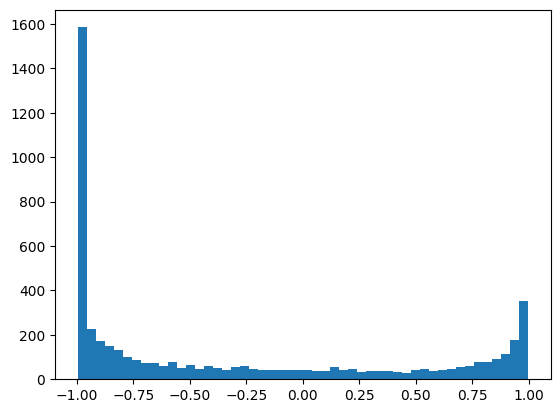

In [49]:
plt.show(plt.hist(preds, bins=50))

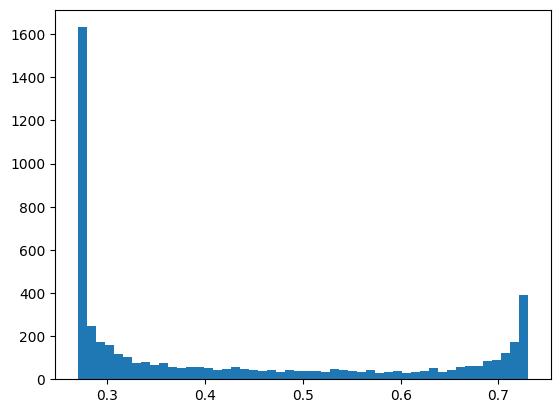

In [50]:
plt.show(plt.hist(torch.sigmoid(preds), bins=50))

In [19]:
import thunder

In [26]:
jit_trained_model = thunder.jit(trained_model.net.net)

In [27]:
preds = jit_trained_model(sample[0])

InterpreterError: Encountered exception AttributeError: module 'dis' has no attribute '_parse_exception_table' while tracing SequentialLitModel(
  (layers): Sequential(
    (0): EncoderLayer(
      (dropout): Dropout(p=0.3, inplace=False)
      (embeddings): EmbeddingLayer(
        (embeddings): ModuleList(
          (0-1): 2 x Embedding(18, 32)
          (2-3): 2 x Embedding(17, 32)
          (4): Embedding(16, 32)
          (5): Embedding(20, 32)
          (6): Embedding(7, 32)
          (7): Embedding(6, 32)
          (8): Embedding(4, 32)
          (9): Embedding(14, 32)
          (10): Embedding(4, 32)
          (11-12): 2 x Embedding(7, 32)
          (13): Embedding(6, 32)
          (14): Embedding(4, 32)
          (15-16): 2 x Embedding(2, 32)
          (17): Embedding(4, 32)
          (18): Embedding(25, 32)
          (19): Embedding(5, 32)
          (20): Embedding(26, 32)
          (21): Embedding(5, 32)
          (22): Embedding(27, 32)
          (23): Embedding(7, 32)
          (24): Embedding(19, 32)
          (25): Embedding(9, 32)
          (26): Embedding(5, 32)
          (27): Embedding(15, 32)
          (28-30): 3 x Embedding(20, 32)
        )
      )
      (out_linear_block): Linear(in_features=992, out_features=32, bias=True)
    )
    (1): GRUSeqToSeq(
      (gru): GRU(32, 32, batch_first=True)
    )
    (2): ConvPooling(
      (pooling_layer): AllPoolings()
      (conv_layer): Conv1d(5, 1, kernel_size=(5,), stride=(1,), padding=same, bias=False)
    )
    (3): MultiOutputLinearBlock(
      (heads): ModuleList(
        (0): LinearBlock(
          (dropout): Dropout(p=0.0, inplace=False)
          (linear_block): Sequential(
            (0): Sequential(
              (0): Linear(in_features=32, out_features=16, bias=True)
              (1): GELU(approximate='none')
              (2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
            )
            (1): Sequential(
              (0): Linear(in_features=16, out_features=8, bias=True)
              (1): GELU(approximate='none')
              (2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
            )
          )
          (out_block): Linear(in_features=8, out_features=1, bias=True)
          (cls_layers): Sequential(
            (0): Dropout(p=0.0, inplace=False)
            (1): Sequential(
              (0): Sequential(
                (0): Linear(in_features=32, out_features=16, bias=True)
                (1): GELU(approximate='none')
                (2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
              )
              (1): Sequential(
                (0): Linear(in_features=16, out_features=8, bias=True)
                (1): GELU(approximate='none')
                (2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
              )
            )
            (2): Linear(in_features=8, out_features=1, bias=True)
            (3): GELU(approximate='none')
          )
        )
      )
    )
  )
):


In [28]:
trained_model.net.to_onnx("credits_history_lit_model.onnx", sample[0], export_params=True)

RuntimeError: Only tuples, lists and Variables are supported as JIT inputs/outputs. Dictionaries and strings are also accepted, but their usage is not recommended. Here, received an input of unsupported type: ModelInput